**写在前面：**本节内容是 [Datawhale五月组队学习 - 集成学习（下）- CH5-集成学习之blending与stacking -【Task13 Stacking算法分析与案例调参实例】](https://github.com/datawhalechina/team-learning-data-mining/tree/master/EnsembleLearning) 的学习笔记，学习周期2天

## 库和数据

In [11]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target
RANDOM_SEED = 42

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = SVC(random_state=RANDOM_SEED)
lr = LogisticRegression()

## Stacking

### 模型构建

In [5]:
sclf = StackingCVClassifier(
    classifiers=[clf1, clf2, clf3],  # 第一层分类器
    use_probas=False, # 是否使用模型输出的概率值(仅可对能输出概率的模型生效)
    meta_classifier=lr,   # 第二层分类器
    random_state=RANDOM_SEED
)

### 3折交叉验证

In [34]:
print('3-fold cross validation:\n')
for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'SVC',
                       'StackingClassifier']):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.95 (+/- 0.01) [SVC]
Accuracy: 0.95 (+/- 0.01) [StackingClassifier]


### 决策边界

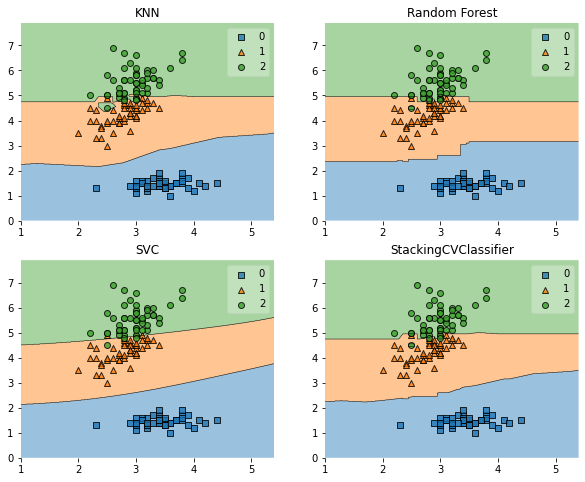

In [36]:
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'SVC',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()

### 网格搜索调参

In [37]:
params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(
    estimator=sclf, 
    param_grid=params, 
    cv=5,
    refit=True
)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.3f' % grid.best_score_)

0.960 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_

### 在不同特征子集上进行

In [15]:
X = iris.data
y = iris.target

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),  # 选择第0,2列
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),  # 选择第1,2,3列
                      LogisticRegression())

sclf = StackingCVClassifier(
    classifiers=[pipe1, pipe2], 
    meta_classifier=LogisticRegression(),
    random_state=RANDOM_SEED)

sclf.fit(X, y)
scores = cross_val_score(sclf, X, y, cv=3, scoring='accuracy')
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.960 (+/- 0.02) [StackingClassifier]


### ROC曲线

In [3]:
X, y = iris.data[:, [0, 1]], iris.target

# 结合OneVSRest实现多分类的二分类处理
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_SEED
)

In [29]:
# OneVsRest用一个分类器对应一个类别，把其他全部的类别作为相反类别看待
classifier = OneVsRestClassifier(sclf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

0 class-Accuracy: 0.72
1 class-Accuracy: 0.72
2 class-Accuracy: 0.72


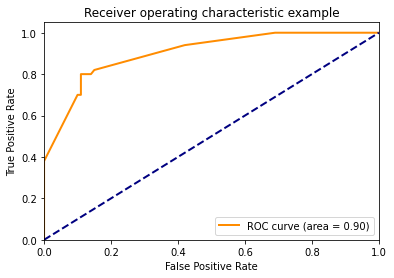

In [28]:
# ROC绘制
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print("%i class-Accuracy: %0.2f" % (i, accuracy_score(y_test, classifier.predict(X_test))))
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(
    fpr['micro'], 
    tpr['micro'], 
    color='darkorange',
    lw=lw, 
    label='ROC curve (area = %0.2f)' % roc_auc['micro']
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()